In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST data
def get_data_loader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

data_loader = get_data_loader()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, latent_dim=8):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.mu = nn.Linear(64, latent_dim)  # Mean
        self.logvar = nn.Linear(64, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = self.mu(encoded), self.logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Loss function (Reconstruction + KL Divergence)
def vae_loss_function(reconstructed_x, x, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

# Training function
def train_vae(model, dataloader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for imgs, _ in dataloader:
            imgs = imgs.view(imgs.size(0), -1).to(device)
            optimizer.zero_grad()
            reconstructed, mu, logvar = model(imgs)
            loss = vae_loss_function(reconstructed, imgs, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")
    return model

# Train the VAE
vae_model = VAE()
vae_trained_model = train_vae(vae_model, data_loader, epochs=10)

Epoch [1/10], Loss: 3263540.6182
Epoch [2/10], Loss: 2526299.3853
Epoch [3/10], Loss: 2200481.4199
Epoch [4/10], Loss: 2070302.8655
Epoch [5/10], Loss: 1999419.0217
Epoch [6/10], Loss: 1956639.4368
Epoch [7/10], Loss: 1926507.8801
Epoch [8/10], Loss: 1902082.6475
Epoch [9/10], Loss: 1883670.8550
Epoch [10/10], Loss: 1868464.9163


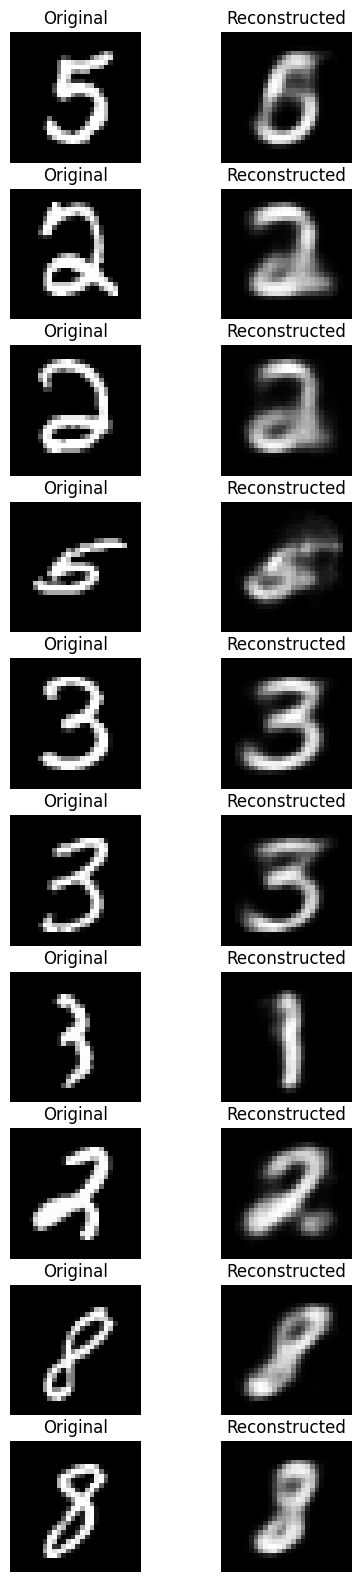

In [3]:
# import torch
# import matplotlib.pyplot as plt

# def evaluate_vae_reconstruction(vae, dataloader, num_samples=10):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     vae.to(device).eval()

#     # Get a batch of real MNIST images
#     images, _ = next(iter(dataloader))
#     images = images[:num_samples].view(num_samples, -1).to(device)

#     # Encode and decode the images
#     with torch.no_grad():
#         reconstructed_images, _, _ = vae(images)
#         reconstructed_images = reconstructed_images.cpu().numpy()

#     # Plot original and reconstructed images
#     fig, axes = plt.subplots(num_samples, 2, figsize=(5, num_samples * 2))
#     for i in range(num_samples):
#         axes[i, 0].imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
#         axes[i, 0].set_title("Original")
#         axes[i, 1].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
#         axes[i, 1].set_title("Reconstructed")
#         axes[i, 0].axis("off")
#         axes[i, 1].axis("off")
#     plt.show()

# # Evaluate VAE reconstruction
# evaluate_vae_reconstruction(vae_trained_model, data_loader)

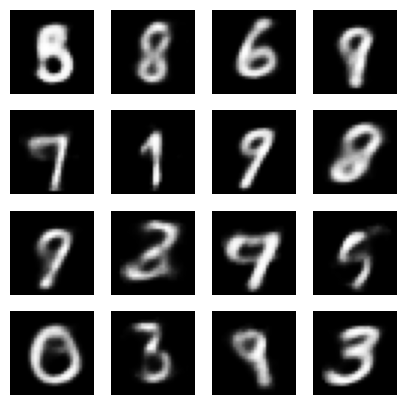

In [4]:
# import torch
# import matplotlib.pyplot as plt

# def generate_images_vae(vae, num_samples=16, latent_dim=8):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     vae.to(device).eval()

#     # Generate random latent vectors from a normal distribution
#     with torch.no_grad():
#         random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)
#         generated_images = vae.decoder(random_latent_vectors).cpu().numpy()

#     # Plot generated images
#     fig, axes = plt.subplots(4, 4, figsize=(5, 5))
#     for i, ax in enumerate(axes.flat):
#         ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
#         ax.axis("off")
#     plt.show()

# # Generate random samples from VAE
# generate_images_vae(vae_trained_model)

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

def get_digit_subset(dataloader, vae, digit=0, num_samples=1000):
    """Extracts all images of a specific digit from the dataset and encodes them using VAE."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()
    digit_images = []
    for images, labels in dataloader:
        mask = labels == digit
        digit_images.append(images[mask])
        if len(torch.cat(digit_images)) >= num_samples:
            break

    digit_images = torch.cat(digit_images)[:num_samples].to(device)  # Take subset and move to device

    # Encode the images using the VAE encoder
    with torch.no_grad():
        encoded_images = vae.encoder(digit_images.view(num_samples, -1))
        mu, logvar = vae.mu(encoded_images), vae.logvar(encoded_images)
        z = vae.reparameterize(mu, logvar)

    return z.cpu().numpy()  # Convert back to numpy

def sample_from_convex_hull(hull, num_samples=16):
    """Generates random points inside the convex hull."""
    points = hull.points
    dim = points.shape[1]
    rand_weights = np.random.dirichlet(alpha=np.ones(len(points)), size=num_samples)
    sampled_points = np.dot(rand_weights, points)  # Convex combination of hull points
    return sampled_points

def decode_and_plot_images(vae, sampled_points):
    """Decodes sampled latent points into images and plots them."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()
    sampled_tensors = torch.tensor(sampled_points, dtype=torch.float32).to(device)

    with torch.no_grad():
        generated_images = vae.decoder(sampled_tensors).cpu().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.axis("off")
    plt.show()

# # Extract only digit 0 from dataset and encode using VAE
# zero_latent_vectors = get_digit_subset(data_loader, vae_trained_model, digit=0, num_samples=1000)

# # Compute convex hull around encoded 0s
# hull = ConvexHull(zero_latent_vectors)

# # Sample random points inside convex hull
# sampled_latent_points = sample_from_convex_hull(hull, num_samples=16)

# # Decode and plot sampled points
# decode_and_plot_images(vae_trained_model, sampled_latent_points)


In [6]:
hulls = []
for digit in range(10):
    digit_latent_vectors = get_digit_subset(data_loader, vae_trained_model, digit=digit)
    hull = ConvexHull(digit_latent_vectors)
    hulls.append(hull)

In [13]:
for i, hull in enumerate(hulls):
  print(f"Digit {i}:")
  print(f"  Area: {hull.area}")
  print(f"  Hull volume: {hull.volume}")


Digit 0:
  Area: 3836.7683211696253
  Hull volume: 766.1930132164407
Digit 1:
  Area: 4371.778494771486
  Hull volume: 888.9578731542583
Digit 2:
  Area: 4809.670743429553
  Hull volume: 1001.1041717619265
Digit 3:
  Area: 5260.247409459104
  Hull volume: 1154.4093086405376
Digit 4:
  Area: 4545.101537204302
  Hull volume: 967.4385147635909
Digit 5:
  Area: 7057.382503430063
  Hull volume: 1508.8719776074959
Digit 6:
  Area: 3598.15687648776
  Hull volume: 698.3923804647306
Digit 7:
  Area: 6593.461761998566
  Hull volume: 1468.9159297074357
Digit 8:
  Area: 4039.498622146724
  Hull volume: 830.347728462836
Digit 9:
  Area: 5009.941198277467
  Hull volume: 1075.9151615845228


The facets of the hull are NOT the corners that form the convex hull nor the edges between adjacent corners creating the convex hull. if you imagine a 3d cube, the facets are the faces created by the vertices and edges. they are an indirect result of the convex hull that partitions inside and outside.

In [8]:
# prompt: for each hull find the ordering of hulls close to it

import numpy as np
def find_closest_hulls(hulls, target_hull_index, num_closest=5):
  """
  Finds the ordering of hulls closest to the target hull.

  Args:
    hulls: A list of ConvexHull objects.
    target_hull_index: The index of the target hull in the list.
    num_closest: The number of closest hulls to find.

  Returns:
    A list of tuples (hull_index, distance) sorted by distance,
    representing the closest hulls to the target hull.
  """
  target_hull = hulls[target_hull_index]
  distances = []
  for i, hull in enumerate(hulls):
    if i != target_hull_index:
      # Calculate distance between the centroids of the hulls
      # (you can use other metrics as needed)
      target_centroid = np.mean(target_hull.points, axis=0)
      hull_centroid = np.mean(hull.points, axis=0)
      distance = np.linalg.norm(target_centroid - hull_centroid)
      distances.append((i, distance))

  distances.sort(key=lambda x: x[1])  # Sort by distance
  return distances[:num_closest]

# Example usage
for i in range(len(hulls)):
  closest_hulls = find_closest_hulls(hulls, i, num_closest=9)
  print(f"Digit {i} closest hulls:")
  for hull_index, distance in closest_hulls:
    print(f"  - Digit {hull_index}, distance: {distance:.2f}")



Digit 0 closest hulls:
  - Digit 5, distance: 1.63
  - Digit 8, distance: 2.17
  - Digit 9, distance: 2.25
  - Digit 6, distance: 2.27
  - Digit 3, distance: 2.36
  - Digit 4, distance: 2.45
  - Digit 2, distance: 2.68
  - Digit 7, distance: 2.92
  - Digit 1, distance: 3.72
Digit 1 closest hulls:
  - Digit 2, distance: 2.34
  - Digit 9, distance: 2.55
  - Digit 4, distance: 2.61
  - Digit 8, distance: 2.61
  - Digit 6, distance: 2.67
  - Digit 7, distance: 2.72
  - Digit 3, distance: 2.84
  - Digit 5, distance: 2.86
  - Digit 0, distance: 3.72
Digit 2 closest hulls:
  - Digit 8, distance: 2.19
  - Digit 6, distance: 2.29
  - Digit 1, distance: 2.34
  - Digit 4, distance: 2.41
  - Digit 3, distance: 2.60
  - Digit 9, distance: 2.64
  - Digit 0, distance: 2.68
  - Digit 5, distance: 2.84
  - Digit 7, distance: 2.90
Digit 3 closest hulls:
  - Digit 5, distance: 1.80
  - Digit 8, distance: 1.93
  - Digit 0, distance: 2.36
  - Digit 2, distance: 2.60
  - Digit 9, distance: 2.66
  - Digit 1,

In [7]:
# prompt: make kd trees from vertices of all hulls

import numpy as np
from scipy.spatial import KDTree

# Assuming you have a list of hulls called 'hulls'
kd_trees = [KDTree(hull.points) for hull in hulls]

In [8]:
# prompt: for each pair of kd trees find the closest point between each tree

import numpy as np
def find_closest_points_between_kdtrees(kd_trees):
  """
  Finds the closest point between each pair of KD trees.

  Args:
    kd_trees: A list of KDTree objects.

  Returns:
    A list of tuples (tree1_index, tree2_index, closest_point_tree1, closest_point_tree2, distance).
  """
  closest_points = []
  for i in range(len(kd_trees)):
    for j in range(i + 1, len(kd_trees)):
      tree1 = kd_trees[i]
      tree2 = kd_trees[j]

      # Find the closest point between the two trees
      distances, indices = tree1.query(tree2.data, k=1)  # Query for the nearest neighbor in tree2 for each point in tree1
      min_distance = np.min(distances)
      min_index = np.argmin(distances)

      closest_point_tree1 = tree1.data[indices[min_index]]
      closest_point_tree2 = tree2.data[min_index]

      closest_points.append((i, j, closest_point_tree1, closest_point_tree2, min_distance))

  return closest_points

# Assuming you have a list of KD trees called 'kd_trees'
closest_points_between_trees = find_closest_points_between_kdtrees(kd_trees)

# Print the closest points between each pair of trees
for tree1_index, tree2_index, closest_point_tree1, closest_point_tree2, distance in closest_points_between_trees:
    print(f"Closest points between trees {tree1_index} and {tree2_index}:")
    # print(f"  - Tree {tree1_index}: {closest_point_tree1}")
    # print(f"  - Tree {tree2_index}: {closest_point_tree2}")
    print(f"  - Distance: {distance:.2f}")


Closest points between trees 0 and 1:
  - Distance: 1.10
Closest points between trees 0 and 2:
  - Distance: 0.62
Closest points between trees 0 and 3:
  - Distance: 0.65
Closest points between trees 0 and 4:
  - Distance: 1.05
Closest points between trees 0 and 5:
  - Distance: 0.56
Closest points between trees 0 and 6:
  - Distance: 0.36
Closest points between trees 0 and 7:
  - Distance: 0.90
Closest points between trees 0 and 8:
  - Distance: 0.77
Closest points between trees 0 and 9:
  - Distance: 0.90
Closest points between trees 1 and 2:
  - Distance: 0.63
Closest points between trees 1 and 3:
  - Distance: 0.72
Closest points between trees 1 and 4:
  - Distance: 0.63
Closest points between trees 1 and 5:
  - Distance: 0.89
Closest points between trees 1 and 6:
  - Distance: 0.71
Closest points between trees 1 and 7:
  - Distance: 0.58
Closest points between trees 1 and 8:
  - Distance: 0.60
Closest points between trees 1 and 9:
  - Distance: 0.59
Closest points between trees 2 

Try interpolating between hull closest vertices and see what that does.

Interpolating between trees 0 and 1:


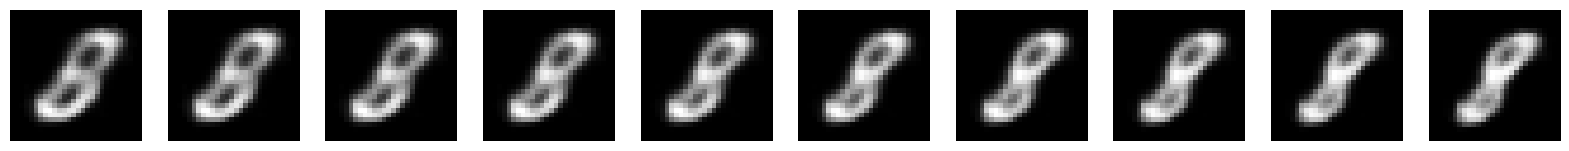

Interpolating between trees 0 and 2:


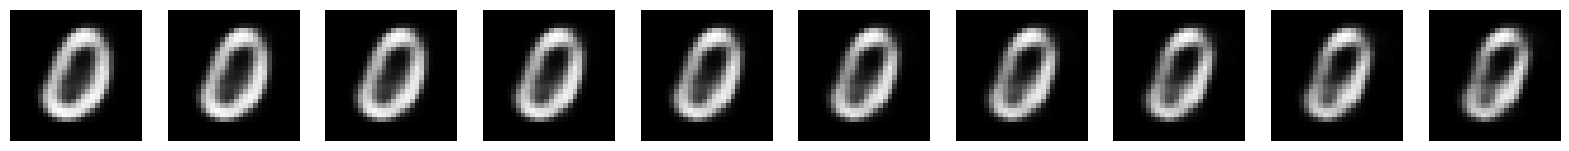

Interpolating between trees 0 and 3:


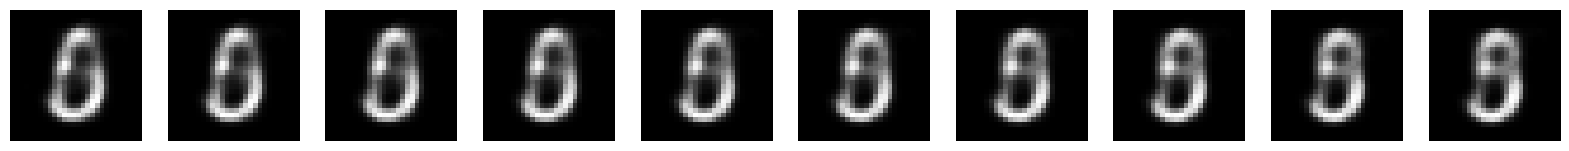

Interpolating between trees 0 and 4:


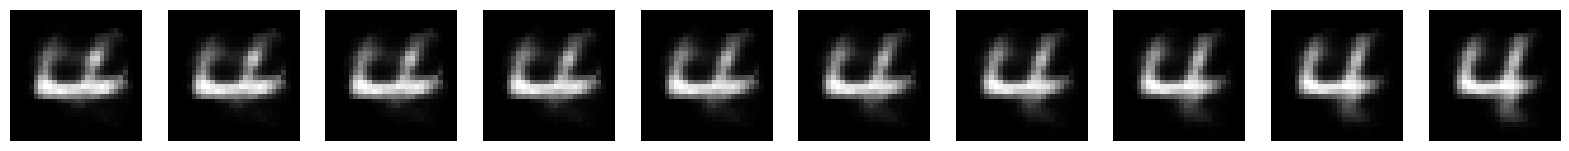

Interpolating between trees 0 and 5:


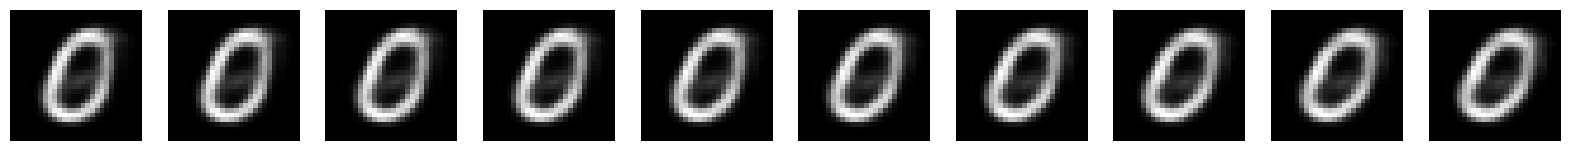

Interpolating between trees 0 and 6:


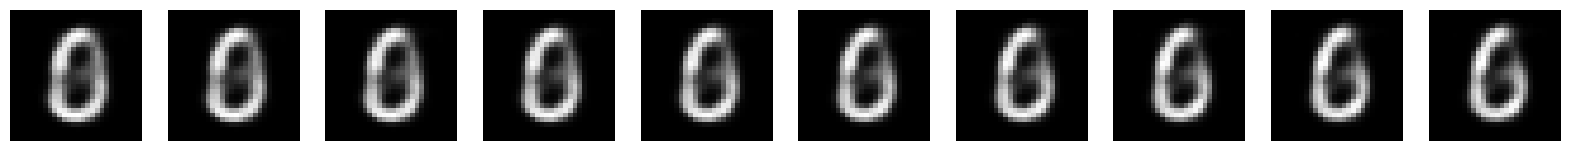

Interpolating between trees 0 and 7:


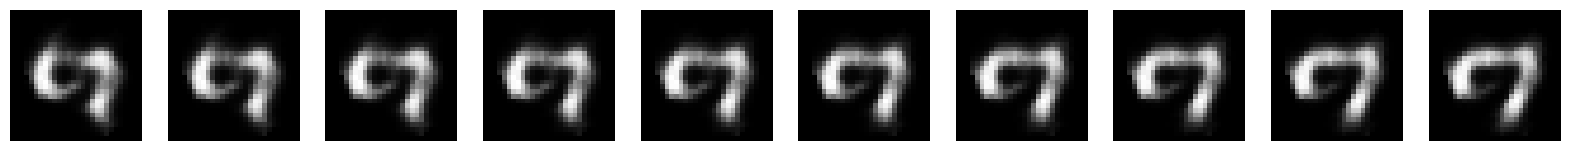

Interpolating between trees 0 and 8:


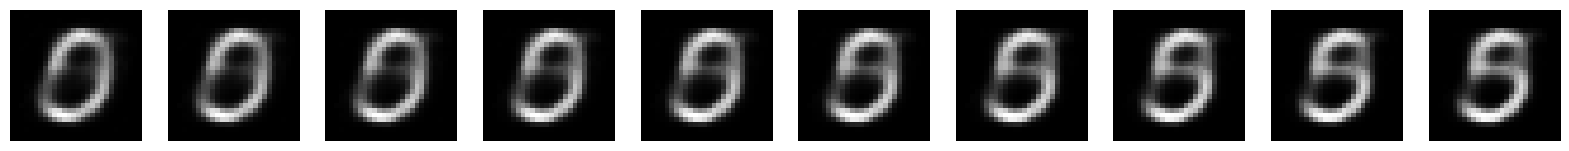

Interpolating between trees 0 and 9:


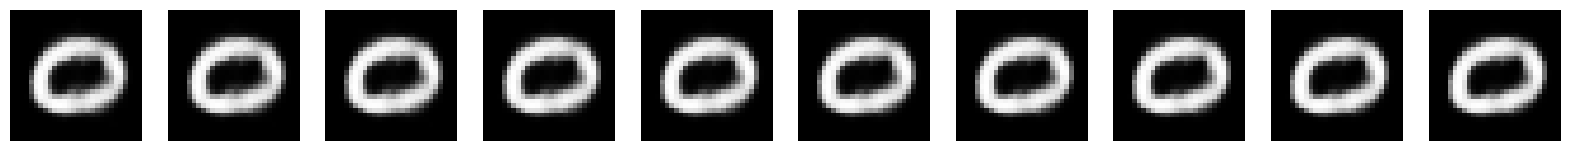

Interpolating between trees 1 and 2:


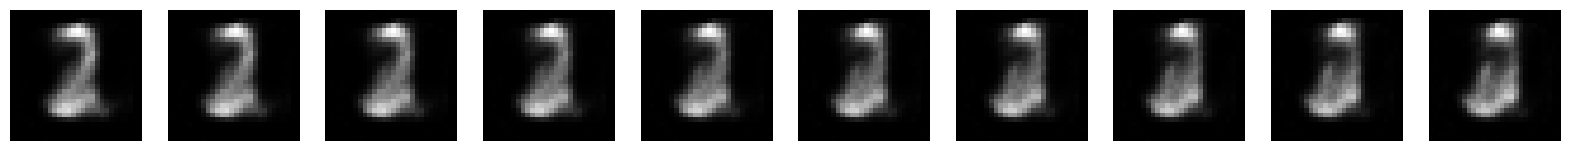

Interpolating between trees 1 and 3:


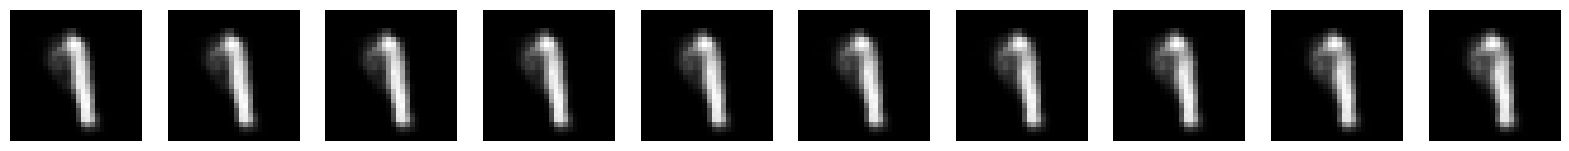

Interpolating between trees 1 and 4:


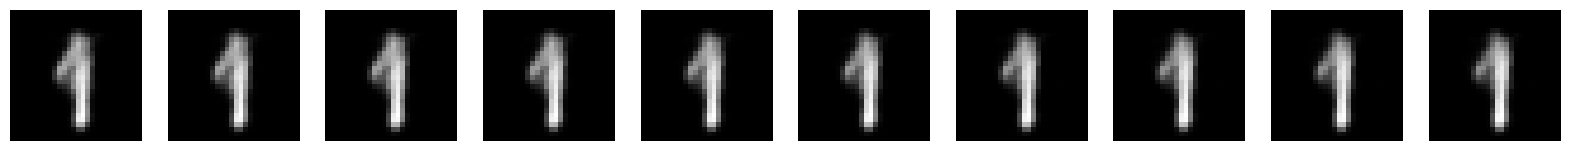

Interpolating between trees 1 and 5:


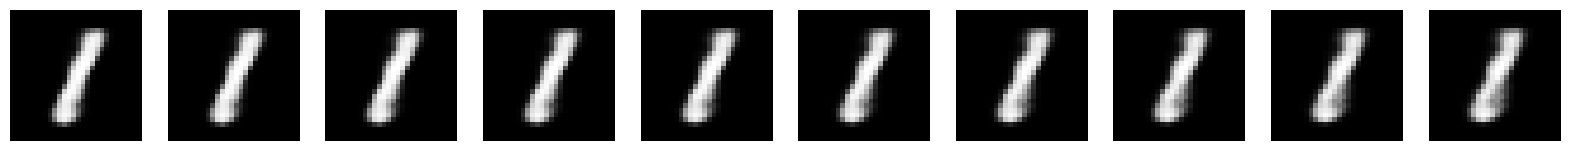

Interpolating between trees 1 and 6:


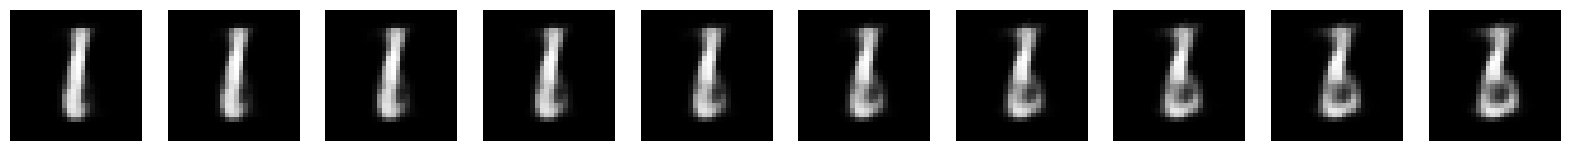

Interpolating between trees 1 and 7:


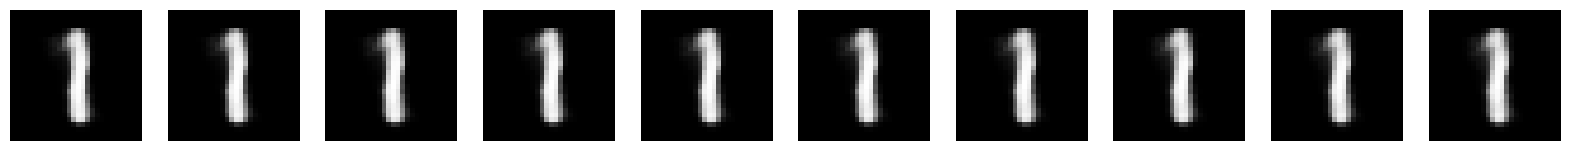

Interpolating between trees 1 and 8:


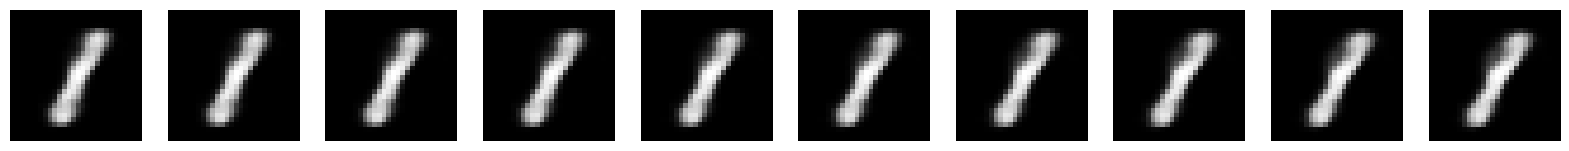

Interpolating between trees 1 and 9:


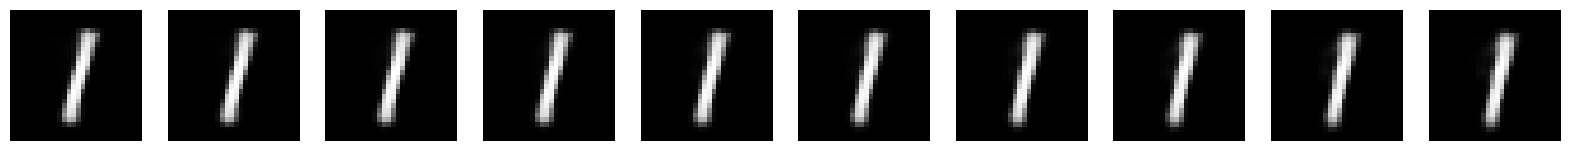

Interpolating between trees 2 and 3:


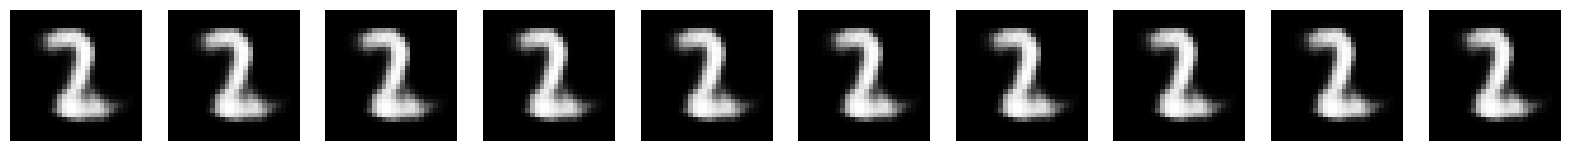

Interpolating between trees 2 and 4:


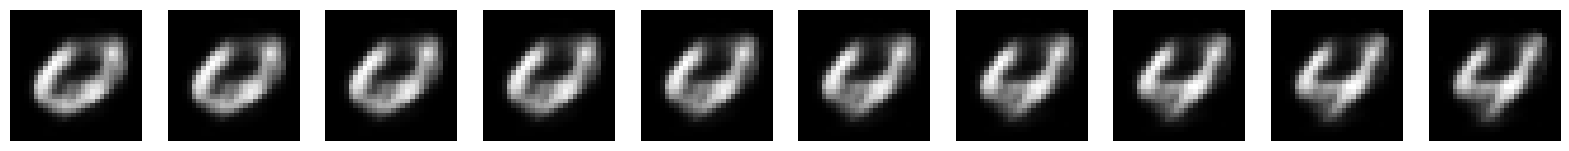

Interpolating between trees 2 and 5:


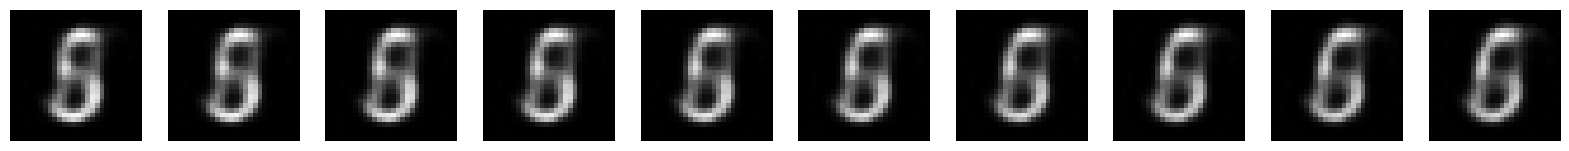

Interpolating between trees 2 and 6:


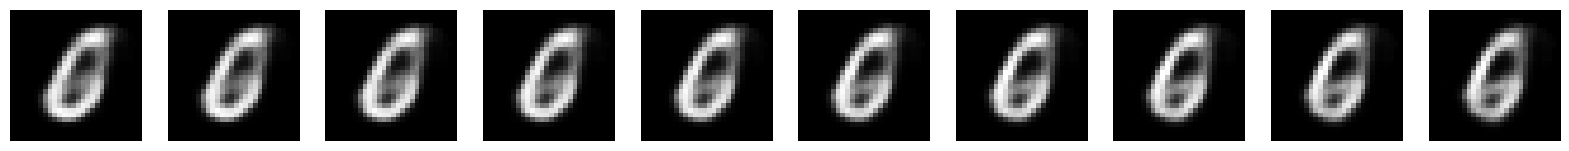

Interpolating between trees 2 and 7:


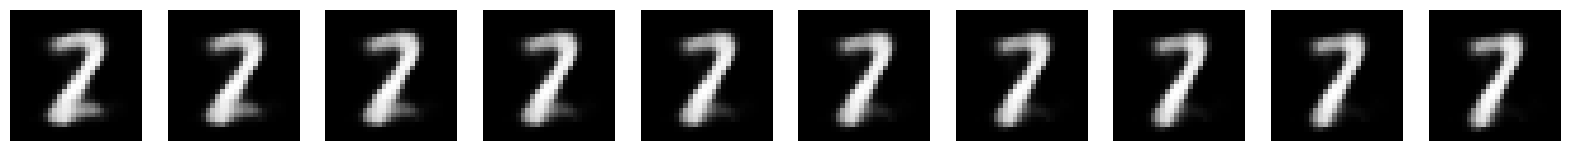

Interpolating between trees 2 and 8:


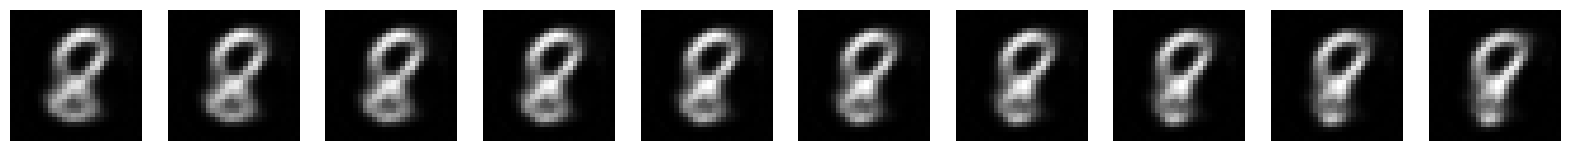

Interpolating between trees 2 and 9:


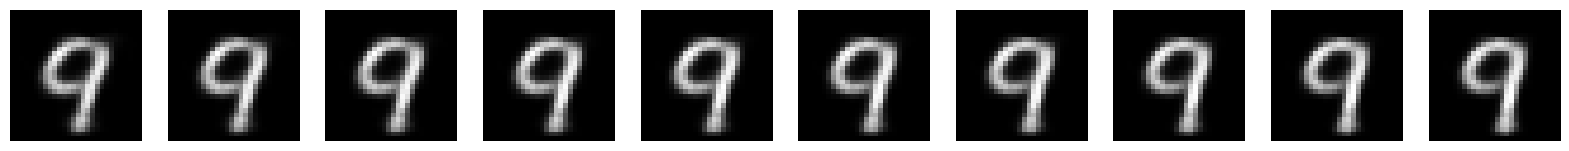

Interpolating between trees 3 and 4:


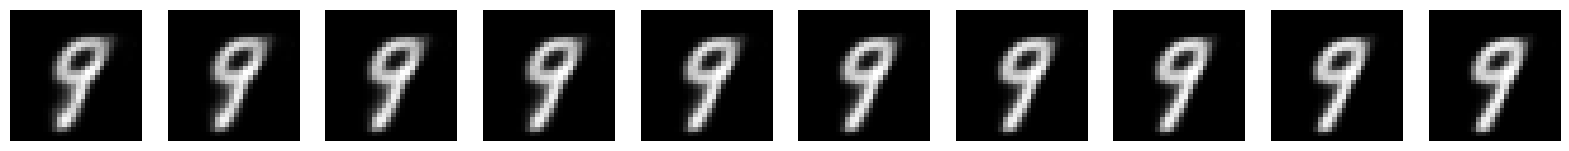

Interpolating between trees 3 and 5:


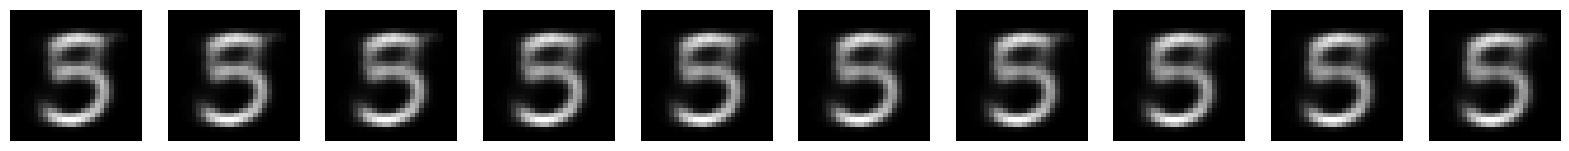

Interpolating between trees 3 and 6:


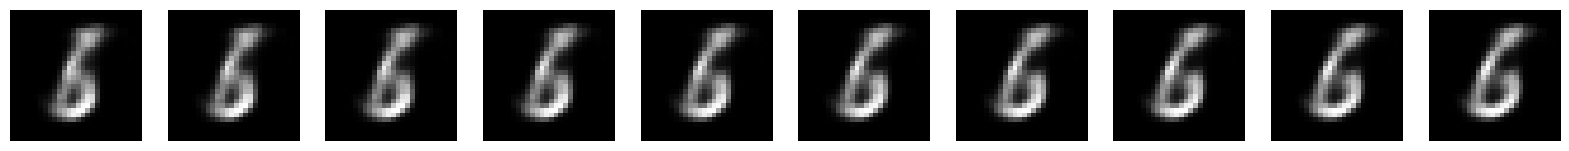

Interpolating between trees 3 and 7:


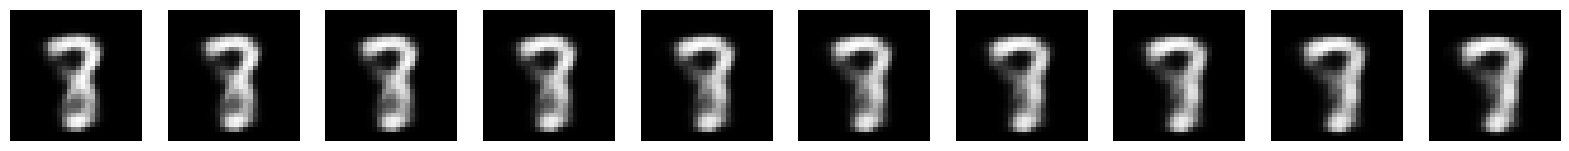

Interpolating between trees 3 and 8:


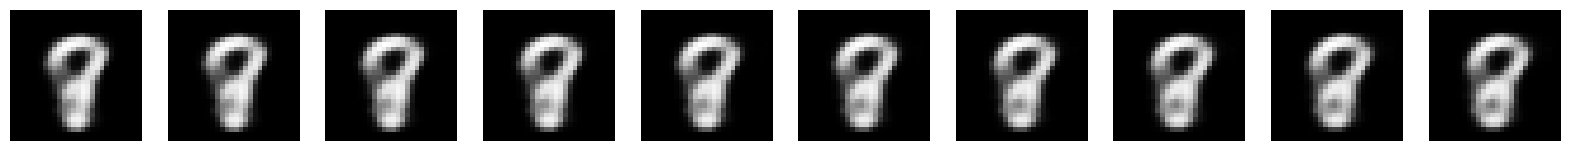

Interpolating between trees 3 and 9:


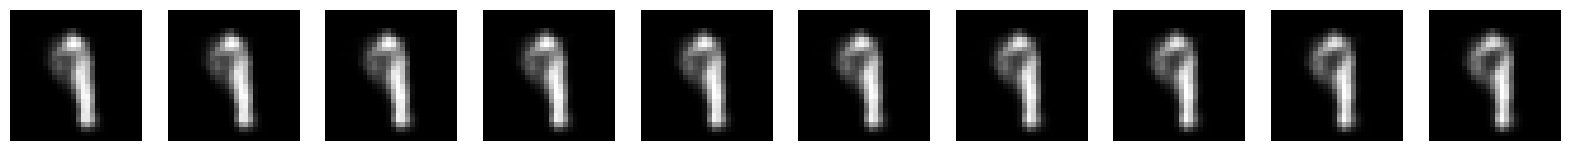

Interpolating between trees 4 and 5:


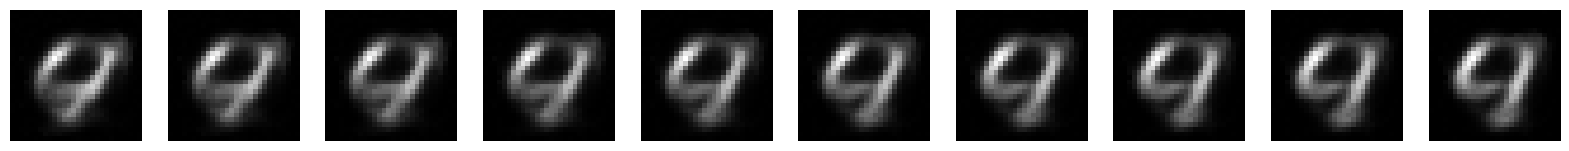

Interpolating between trees 4 and 6:


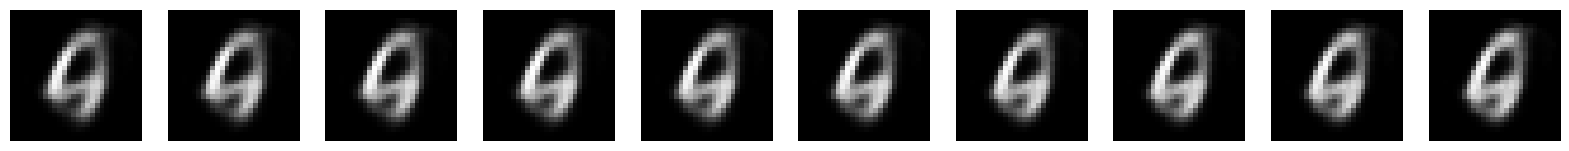

Interpolating between trees 4 and 7:


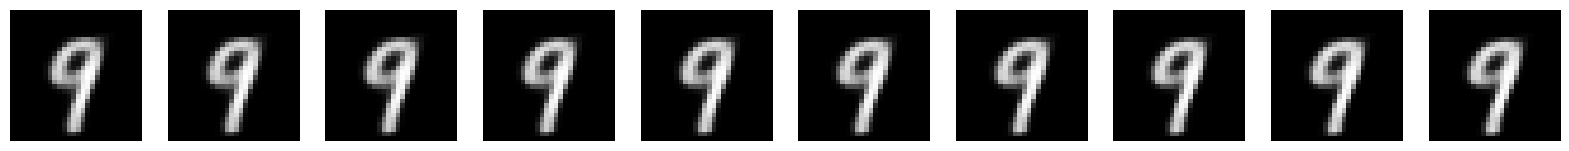

Interpolating between trees 4 and 8:


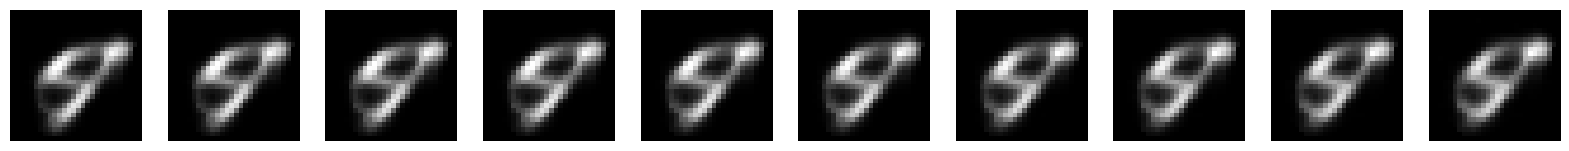

Interpolating between trees 4 and 9:


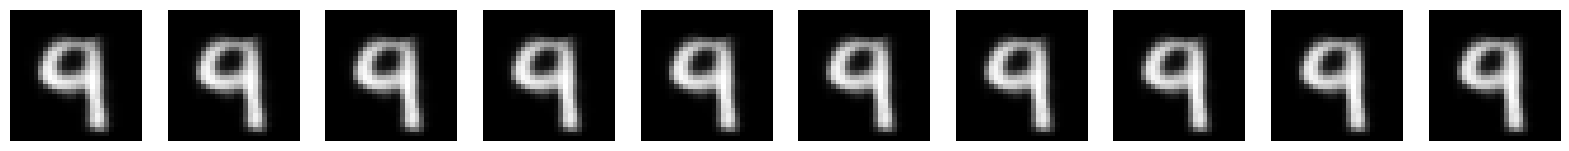

Interpolating between trees 5 and 6:


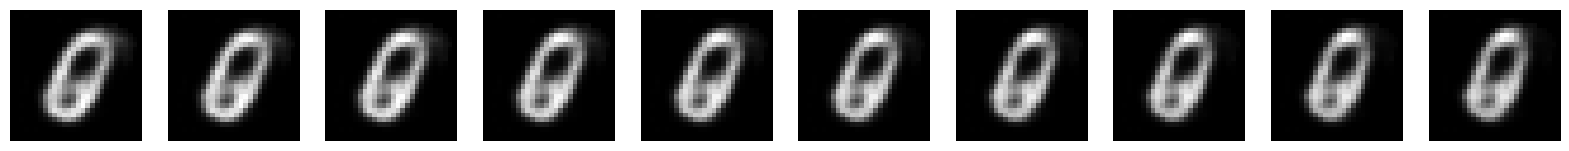

Interpolating between trees 5 and 7:


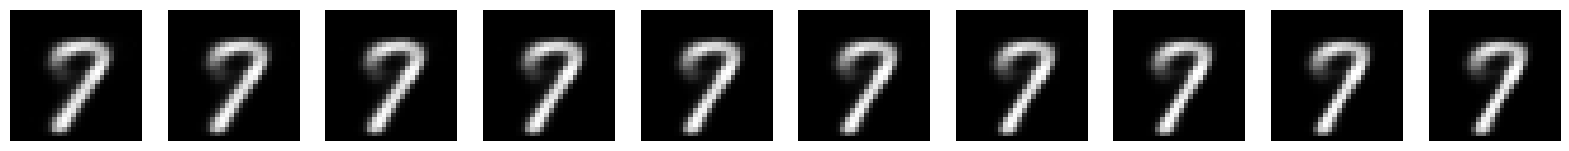

Interpolating between trees 5 and 8:


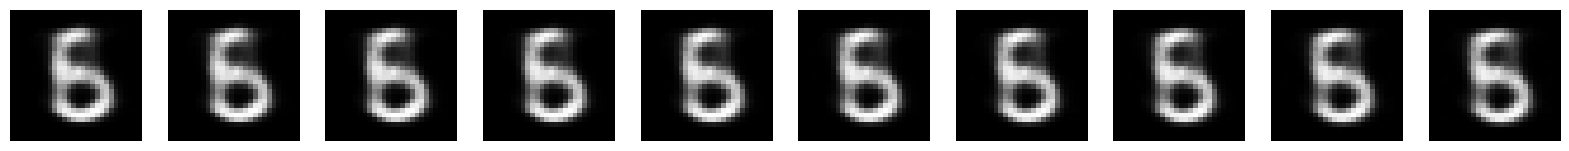

Interpolating between trees 5 and 9:


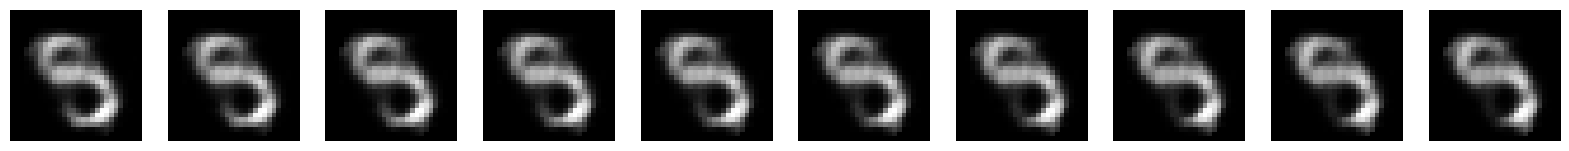

Interpolating between trees 6 and 7:


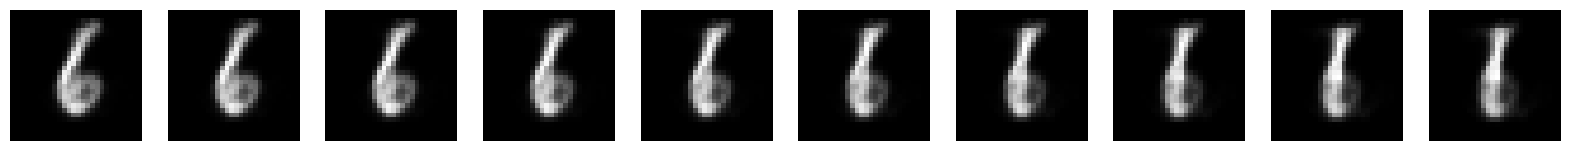

Interpolating between trees 6 and 8:


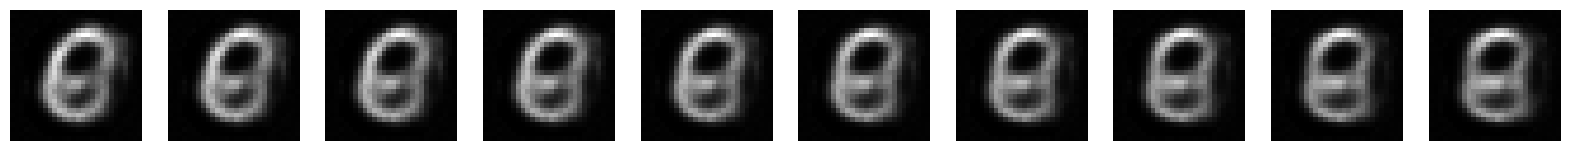

Interpolating between trees 6 and 9:


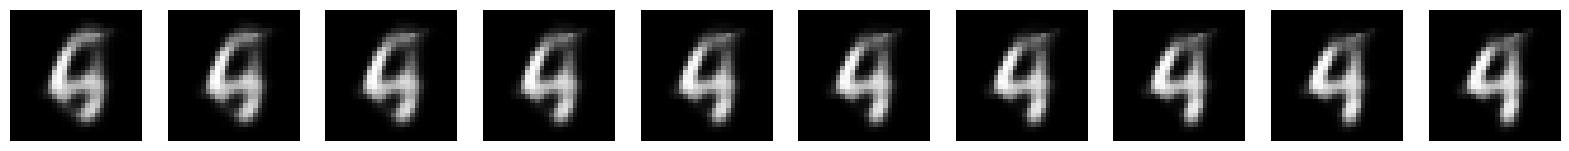

Interpolating between trees 7 and 8:


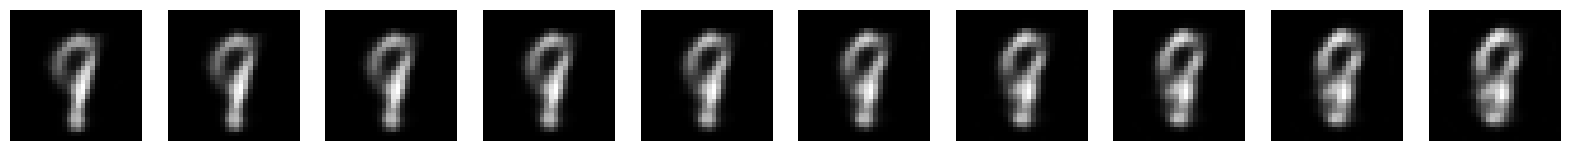

Interpolating between trees 7 and 9:


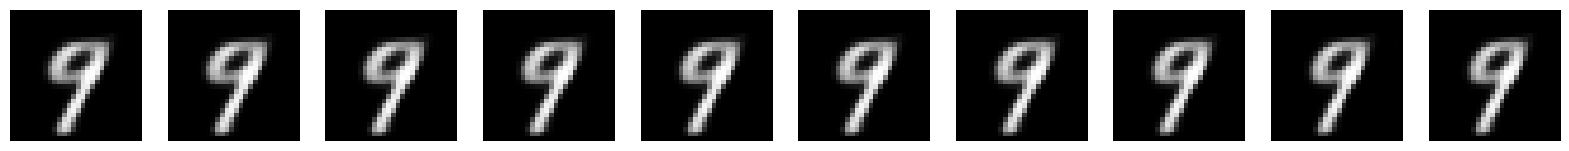

Interpolating between trees 8 and 9:


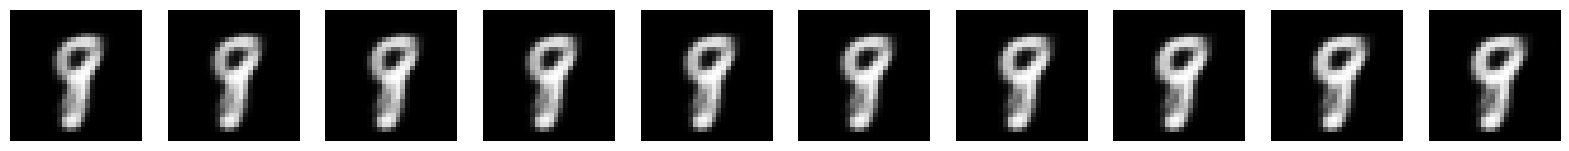

In [53]:
# prompt: for each pair of closest points between hulls, interpolate between the points at 0, 25, 50, 75, 100% and decode them to see the image

import matplotlib.pyplot as plt
# Try interpolating between hull closest vertices and see what that does.
def interpolate_and_decode(vae, point1, point2, steps=10):
    """Interpolates between two points in latent space and decodes the resulting points."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()

    interpolation_points = []
    for i in range(steps):
        ratio = i / (steps - 1)  # Ratio from 0 to 1
        interpolated_point = (1 - ratio) * point1 + ratio * point2
        interpolation_points.append(interpolated_point)

    interpolation_tensors = torch.tensor(interpolation_points, dtype=torch.float32).to(device)

    with torch.no_grad():
        generated_images = vae.decoder(interpolation_tensors).cpu().numpy()

    fig, axes = plt.subplots(1, steps, figsize=(steps * 2, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.axis("off")
    plt.show()

# Iterate through the closest pairs of points between kd trees
for tree1_index, tree2_index, closest_point_tree1, closest_point_tree2, distance in closest_points_between_trees:
    print(f"Interpolating between trees {tree1_index} and {tree2_index}:")
    interpolate_and_decode(vae_trained_model, closest_point_tree1, closest_point_tree2)


Hull for digit 0:


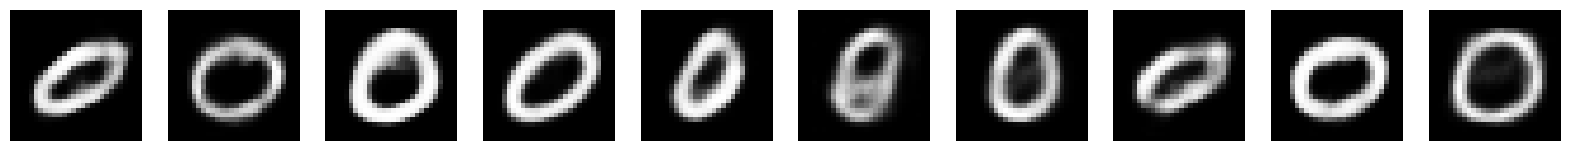

Hull for digit 1:


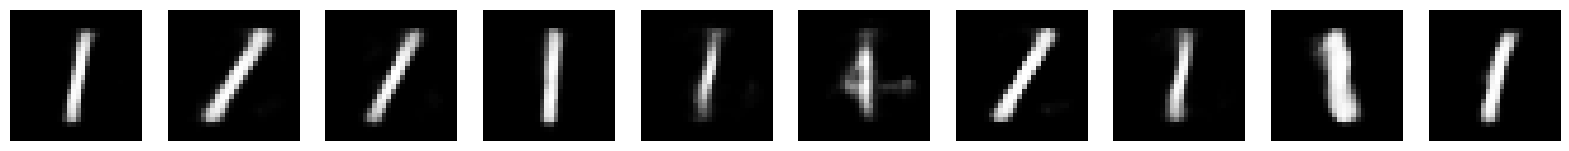

Hull for digit 2:


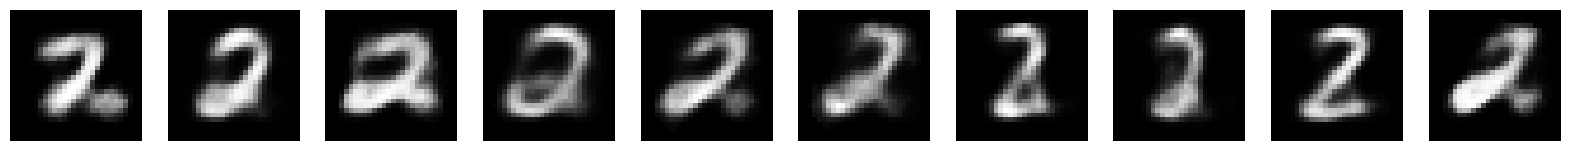

Hull for digit 3:


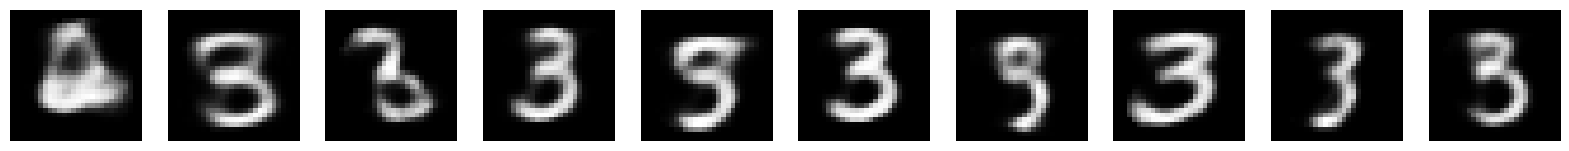

Hull for digit 4:


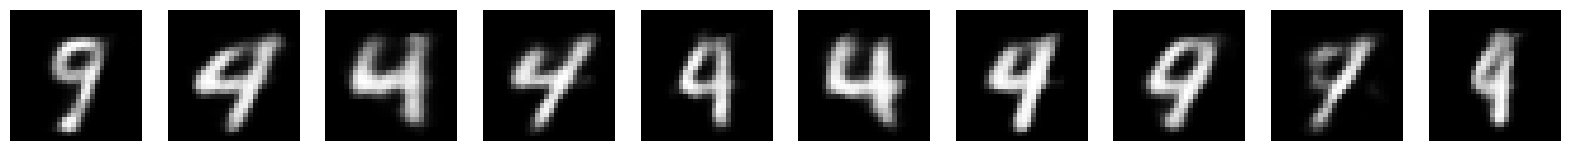

Hull for digit 5:


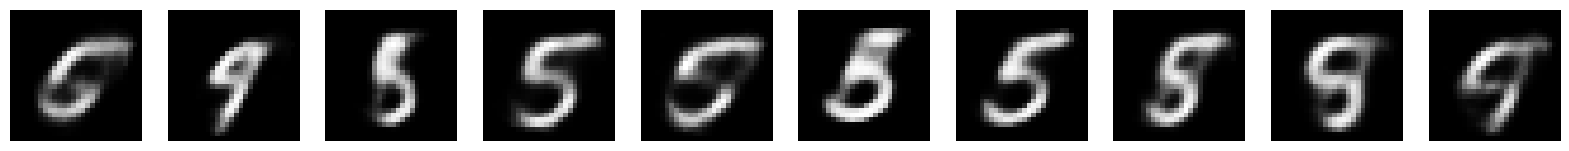

Hull for digit 6:


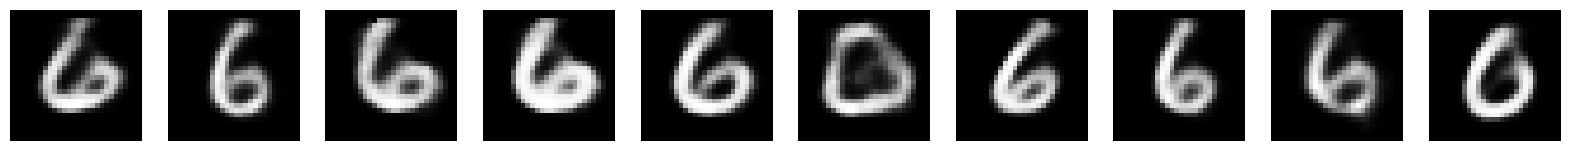

Hull for digit 7:


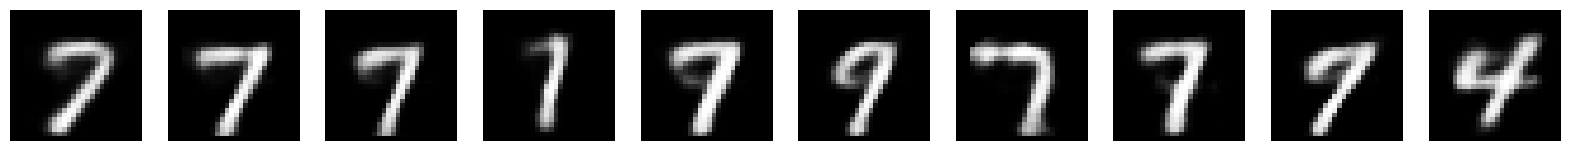

Hull for digit 8:


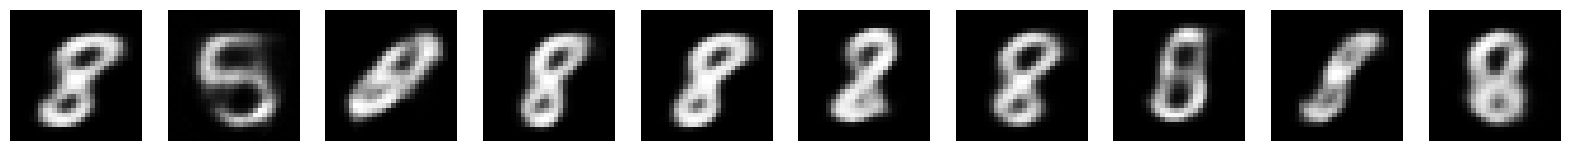

Hull for digit 9:


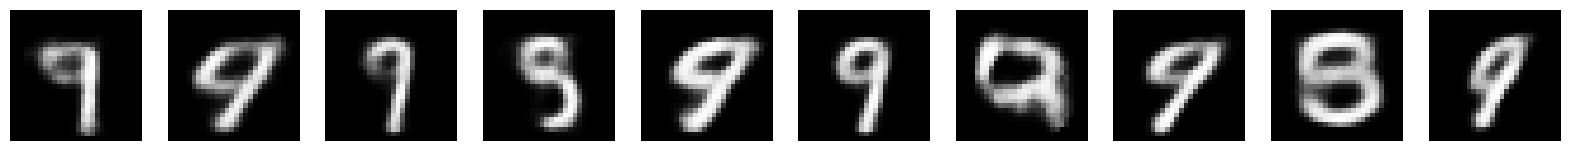

In [12]:
# prompt: go around each hull vertices and pick 10 evenly spaced vertices and decode them

import matplotlib.pyplot as plt
# Assuming you have a list of hulls called 'hulls' and a KDTree for each hull in 'kd_trees'
# Also, assume 'vae_trained_model' is your trained VAE model


def decode_and_plot_vertices(vae, vertices):
    """Decodes sampled latent points into images and plots them."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device).eval()
    sampled_tensors = torch.tensor(vertices, dtype=torch.float32).to(device)

    with torch.no_grad():
        generated_images = vae.decoder(sampled_tensors).cpu().numpy()

    fig, axes = plt.subplots(1, len(vertices), figsize=(len(vertices) * 2, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.axis("off")
    plt.show()


for i, hull in enumerate(hulls):
  print(f"Hull for digit {i}:")
  vertices = hull.vertices
  num_vertices = len(vertices)
  step_size = max(1, num_vertices // 10)  # Ensure at least 10 samples

  sampled_vertices_indices = vertices[::step_size][:10]
  sampled_vertices = hull.points[sampled_vertices_indices]
  decode_and_plot_vertices(vae_trained_model, sampled_vertices)


In [9]:
!pip install giotto-tda

In [14]:
from gtda.homology import VietorisRipsPersistence
import numpy as np

# Get latent vectors for all digits
latent_vectors = []
for digit in range(10):
    digit_vectors = get_digit_subset(data_loader, vae_trained_model, digit=digit, num_samples=100)
    latent_vectors.append(digit_vectors)
latent_vectors = np.vstack(latent_vectors)

# Compute persistent homology
homology_dimensions = [0, 1, 2]  # Look for connected components, loops, and voids
vr = VietorisRipsPersistence(homology_dimensions=homology_dimensions)
persistence_diagrams = vr.fit_transform(latent_vectors[None, :, :])

# Plot persistence diagrams
from gtda.plotting import plot_diagram
plot_diagram(persistence_diagrams[0])

In [16]:
from google.colab import _message

# Get notebook JSON data
nb = _message.blocking_request('get_ipynb')['ipynb']

# Extract and print code from all cells
for i, cell in enumerate(nb['cells']):
    if cell['cell_type'] == 'code':
        print(f"### CELL {i} ###")
        print(''.join(cell['source']))
        print("\n--- CELL SEPARATOR ---\n")

### CELL 0 ###
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST data
def get_data_loader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

data_loader = get_data_loader()

--- CELL SEPARATOR ---

### CELL 1 ###
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, latent_dim=8):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU